# CausalML Lecture 5: Heterogeneus Treatment Effect

"The average causal effect T is an _average_ and as such enjoys all the advantages and disadvantages of averages." – P. W. Holland

**Giorgio Coppola**  
**Xiaohan Wu**

---

## Setup Instructions

To replicate this environment and run this notebook with the exact same package versions using poetry like in Lecture 1:

1. **Install dependencies**:
   ```bash
   poetry install
   ```
   This will create a virtual environment and install all dependencies specified in `pyproject.toml`. Learn more about [dependency management](https://python-poetry.org/docs/dependency-specification/).

2. **Create and install the Jupyter kernel**:
   ```bash
   poetry run python -m ipykernel install --user --name=lecture-5-env --display-name="CausalML Lecture 5"
   ```
   The `poetry run` command executes commands within the Poetry virtual environment. See [Poetry environment management](https://python-poetry.org/docs/managing-environments/).

3. **Start Jupyter**:
   ```bash
   poetry run jupyter notebook
   ```

4. **Select the kernel**: In Jupyter, go to Kernel → Change Kernel → "CausalML Lecture 5"

For more information about Poetry and its features, visit the [official Poetry documentation](https://python-poetry.org/docs/).

---

## Quick recap form Lecture 5 and previous  

#### Until now, we **focused on the ATE** in experimental or nonrandomized observational settings, using **global information!**  

For this, **modeling (including ML) helps:** we can adjust for pre-treatment covariates, balance with weights, or do both. These approaches help because they **exploit covariates information to approximate missing counterfactuals** and to implement the assumption of conditional ignorability when it’s plausible.  

- In **experimental settings,** ignorability holds by design; covariate adjustment mainly improves precision (and can mitigate sample imbalance and noncompliance), while weighting rebalances covariates to address observed selection bias when randomization fails (if we have overlap). Doubly robust estimators combine outcome and treatment models and are consistent if either is correctly specified.  

- In **observational settings,** identification relies on **conditional ignorability** given selected pre-treatment covariates (plus overlap and SUTVA). Models and weights (or both), if they are correctly specified, can help replace the assumption of independence with a less stringent conditional version, yielding to a consistent ATE.  

#### **With HTE, this is harder:** we need local information, but **local information is scarce!**   

We want to estimate a **causal effect that vary across units**. Problem: we cannot make causal claims about specific individuals with certainty!  

When estimating HTE, we are interested in **ITE or CATE conditional on groups defined by X**. We cannot estimate ITE, but CATE is a compromise. However, as X-defined groups get finer, we can lose overlap locally, we don't have sufficient treatment and control units for each X-defined groups &rarr; **curse of dimensionality**.

As **we don't have an observable target** (counterfactual), we don't have a natural loss function and a validation set. This means that the HTE true signal that an estimator can estimate is small relative to the noise, and naïve ML approaches like "T-learners" or "S-learners" are prone to high variance/overfitting. They usually mistake prognostic signal (features that predict baseline risk) and treatment assignment signal (propensity) for causal moderation (the features that change how much treatment effect vary): you might highlight **spurious heterogeneity**.

The challenge is **recover CATEs without chasing noise** and report uncertainty that’s credible. 
To do so, we need methods that build a valid loss with orthogonal/pseudo-outcomes and cross-fitting like 
- **causal forests**,
- **X-learners**, and
- **DR-learners**,  

so we can target CATE τ(x), rather than modeling the outcome Y alone.  

We are going to show some of them, and how they can help!

---


# Simulation Plan: HTE Estimation

## Aims  

Show, via a Monte Carlo simulation, that:  

1. **Naïve ML for HTE (S/T-learners)** mostly learns prognosis or amplifies noise.   
2. **Causal Forests** (Wager–Athey, 2018) recover heterogeneity and enable inference when overlap is decent.  
3. **Meta-learners (X-learner; DR-learner)** (Künzel et al., 2019; Kennedy, 2020) recover heterogeneity also with imbalance.  

---

## Data Generating Mechanism  

We simulate two scenarios:  

- **Balanced treatment assignment** across covariates $X$.  
- **Imbalanced assignment** (treatment more likely at high $X$ values), to make things **worse** for naïve learners!

**Setup:**  

- **Covariates:** Ten features give enough richness for prognosis and treatment effect to depend on different things
  $$
  X = (X_1, \dots, X_{10}) \sim \mathcal{N}(0,1).
  $$  
- **Potential outcomes** with some noise: 
  $$
  Y(0) = \mu(X) + \varepsilon, \quad 
  Y(1) = \mu(X) + \tau(X) + \varepsilon, \quad 
  \varepsilon \sim \mathcal{N}(0,1).
  $$  
- **Baseline outcome (prognosis):** We add nonlinearities & interactions.  
  If $\mu(X)$ (prognosis) is large/complex and $\tau(X)$ is modest, the best way to reduce squared error is to learn $\mu(X)$ very well. This is what naïve learners do: nothing in the loss forces them to isolate $\tau(X)$.
  $$
  \mu(x) = 2\sin(X_1) + 1.25X_2 + 1.5\mathbf{1}\{X_3>0\} + 0.75X_4X_5 + |X_6|
  $$  
- **True treatment effect (CATE):** We add moderation.  
  $\tau$ depends partly on the same variables as $\mu$ (e.g., $X1$,$X3$) but not in the same way, and also on regions of $X2$. This creates moderation.
  $$
  \tau(x) = 1 + 0.8\mathbf{1}\{X_1>0\} - 0.8\mathbf{1}\{X_2>1\} + \sin(X_3/2), \quad 
  \tau(x) \in [-2.5, 2.5].
  $$  
- **Treatment assignment:**  
  - *Balanced:* propensities near 0.5 with little X-dependence.  
    $$
    e(x) = \sigma(0.1X_1 - 0.1X_2 + 0.1X_7)
    $$  
  - *Imbalanced:* units have high or low propensities.
That creates regions with few controls or few treated, and it's useful to show the limitation and streght of methods.
    $$
    e(x) = \sigma(-1 + 1.0X_1 + 0.8X_2 + 0.5X_7)
    $$  
  - $ A \sim \text{Bernoulli}(e(x)) $.  

---

## Assumptions  

- **Conditional ignorability:**  $Y(a) \perp A \mid X$  
- **Overlap:**  $0 < P(A=1 \mid X) < 1$  
- **SUTVA:** Stable unit treatment values, no interference.  

---

## Estimands  

- **CATE:** $ \tau(x) $ evaluated on test set.  
- **ATE:** $ \mathbb{E}[\tau(X)] $ to check if our CATE $ \tau(x) $ integrates to the right average effect.

---

## Methods  

**Baselines (expected to fail):**  
- **S-learner:** one outcome model $ m(a,x) $, $ \tau(x) = m(1,x) − m(0,x)$.  
- **T-learner:** separate outcome models by arm, subtract predictions.  

**Solutions:**  
- **Causal Forest** (Wager–Athey, 2018).  
- **X-learner** (Künzel et al., 2019) with tree base models.  
- _(If we manage)_ **DR-learner** (Kennedy, 2020).  

---

## Performance Metrics  

- **CATE estimation error (MSE):** Measures how close our predicted CATEs are to the true CATEs pointwise  
  $$
  \text{MSE} = \mathbb{E}\left[(\hat{\tau}(x) - \tau(x))^2\right]
  $$
  
- **ATE recovery:** compare $ \hat{\text{ATE}} = \mathbb{E}[\hat{\tau}(x)] $ vs. true ATE.
  Even if pointwise CATEs are noisy, a good method should still get the average effect right. If $\hat{ATE}$ is far from $ATE_{True}$ , the model is systematically biased.
  
- **Scatter plot:** compare $\hat{\tau}(x)$ vs. true $\tau(x)$.

- _(If we manage)_ **Calibration plots:**  
Do high predicted CATEs correspond to actually larger realized effects?    
  - Bin units by predicted CATE ($\hat{\tau}(x)$).  
  - X-axis = average predicted CATE in bin.  
  - Y-axis = realized treatment effect in bin.
     
---

## Overlap Check  

- Plot propensity score distributions (treated vs control).  
- Explain where methods fail when overlap is poor.  

---

## Expected Results

- **Balanced assignment:** S/T-learners capture prognosis, not treatment effect; poor calibration. Causal Forest and X-learner align more closely with true CATE.  
- **Imbalanced assignment:** S/T degrade further (follow propensity & prognosis). X-learner helps under imbalance; Causal Forest performs well when overlap exists but fails in low-overlap pockets.  
- **Key lesson:** Without orthogonalization and overlap, naïve ML misleads us about heterogeneity.  


## Simulation

### Setup environment


In [6]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_point, theme_minimal, theme
import plotnine as p9

from econml.metalearners import XLearner
from econml.dml import CausalForestDML

p9.theme_set(theme_minimal() + theme(legend_position="bottom"))
np.random.seed(12345)

ModuleNotFoundError: No module named 'econml'

### Data Generation Functions

These functions define how our data is generated. We start with defining a population to sample from, a way to take a sample from that population and then finally how we will run an experiment within that sample.

In [8]:
def generate_population(N):
    """Generate fixed population using same DGP as Lecture 1"""
    x = np.random.uniform(size = N, high = 5)
    y0 = 10 - np.exp(x / 3) + np.random.normal(size = N, scale = 0.2)
    y1 = 10 - np.exp(x / 5) + np.random.normal(size = N, scale = 0.2)
    return pd.DataFrame({'x': x, 'y0': y0, 'y1': y1})

def srswor(n, population):
    """Simple random sample without replacement"""
    return population.sample(n=n).reset_index(drop=True)

def rct(n1, sample):
    """Completely randomized experiment"""
    n = len(sample)
    n0 = int(n - n1)
    a = np.random.choice([1] * n1 + [0] * n0, replace = False, size = n)
    y = a * sample["y1"] + (1 - a) * sample["y0"]
    result = sample.copy()
    result['a'] = a
    result['y'] = y
    return result

def estimate_unadjusted(experiment):
    """Unadjusted difference-in-means estimator with Neyman variance"""
    y_t = experiment[experiment["a"] == 1]["y"]
    y_c = experiment[experiment["a"] == 0]["y"]
    
    tau_hat = y_t.mean() - y_c.mean()
    
    # Neyman variance estimator
    n_t, n_c = len(y_t), len(y_c)
    s2_t = y_t.var(ddof=1) if n_t > 1 else 0
    s2_c = y_c.var(ddof=1) if n_c > 1 else 0
    var_hat = s2_t / n_t + s2_c / n_c
    se_hat = np.sqrt(var_hat)
    
    return {
        "tau_hat": tau_hat,
        "se_hat": se_hat,
        "ci_lower": tau_hat - 1.96 * se_hat,
        "ci_upper": tau_hat + 1.96 * se_hat
    }

def estimate_linear_adjustment(experiment):
    """Linear regression adjustment: Y ~ A + X with HC2 standard errors"""
    # Prepare design matrix
    X = sm.add_constant(experiment[['a', 'x']])
    y = experiment['y']
    
    # Fit OLS model with HC2 standard errors
    model = sm.OLS(y, X).fit(cov_type="HC2")
    
    tau_hat = model.params['a']
    se_hat = model.bse['a']
    
    return {
        "tau_hat": tau_hat,
        "se_hat": se_hat,
        "ci_lower": tau_hat - 1.96 * se_hat,
        "ci_upper": tau_hat + 1.96 * se_hat
    }

def estimate_lin_method(experiment):
    """Lin's saturated model: Y ~ A + X_centered + A*X_centered with HC2 standard errors"""
    df = experiment.copy()
    
    # Center covariates
    df['x_centered'] = df['x'] - df['x'].mean()
    df['a_x_interaction'] = df['a'] * df['x_centered']
    
    # Prepare design matrix
    X = sm.add_constant(df[['a', 'x_centered', 'a_x_interaction']])
    y = df['y']
    
    # Fit OLS model with HC2 standard errors
    model = sm.OLS(y, X).fit(cov_type="HC2")
    
    tau_hat = model.params['a']
    se_hat = model.bse['a']
    
    return {
        "tau_hat": tau_hat,
        "se_hat": se_hat,
        "ci_lower": tau_hat - 1.96 * se_hat,
        "ci_upper": tau_hat + 1.96 * se_hat
    }

def estimate_effects(experiment, methods=["unadjusted", "linear", "lin"]):
    """Estimate treatment effects using different covariate adjustment methods"""
    results = {}
    
    estimators = {
        "unadjusted": estimate_unadjusted,
        "linear": estimate_linear_adjustment, 
        "lin": estimate_lin_method
    }
    
    for method in methods:
        results[method] = estimators[method](experiment)
    
    return results

## Exploration

### Properties of the population

We will first examine fixed properties of the population. Once we generate a population (for our simulation), these properties are not assumed to be "random" at all.

Let's define the size of our population, sample and treatment group as parameters which we can tinker with to see how it changes results.

In [9]:
N_POPULATION = 200
N_SAMPLE = 40
N_TREATED = 20

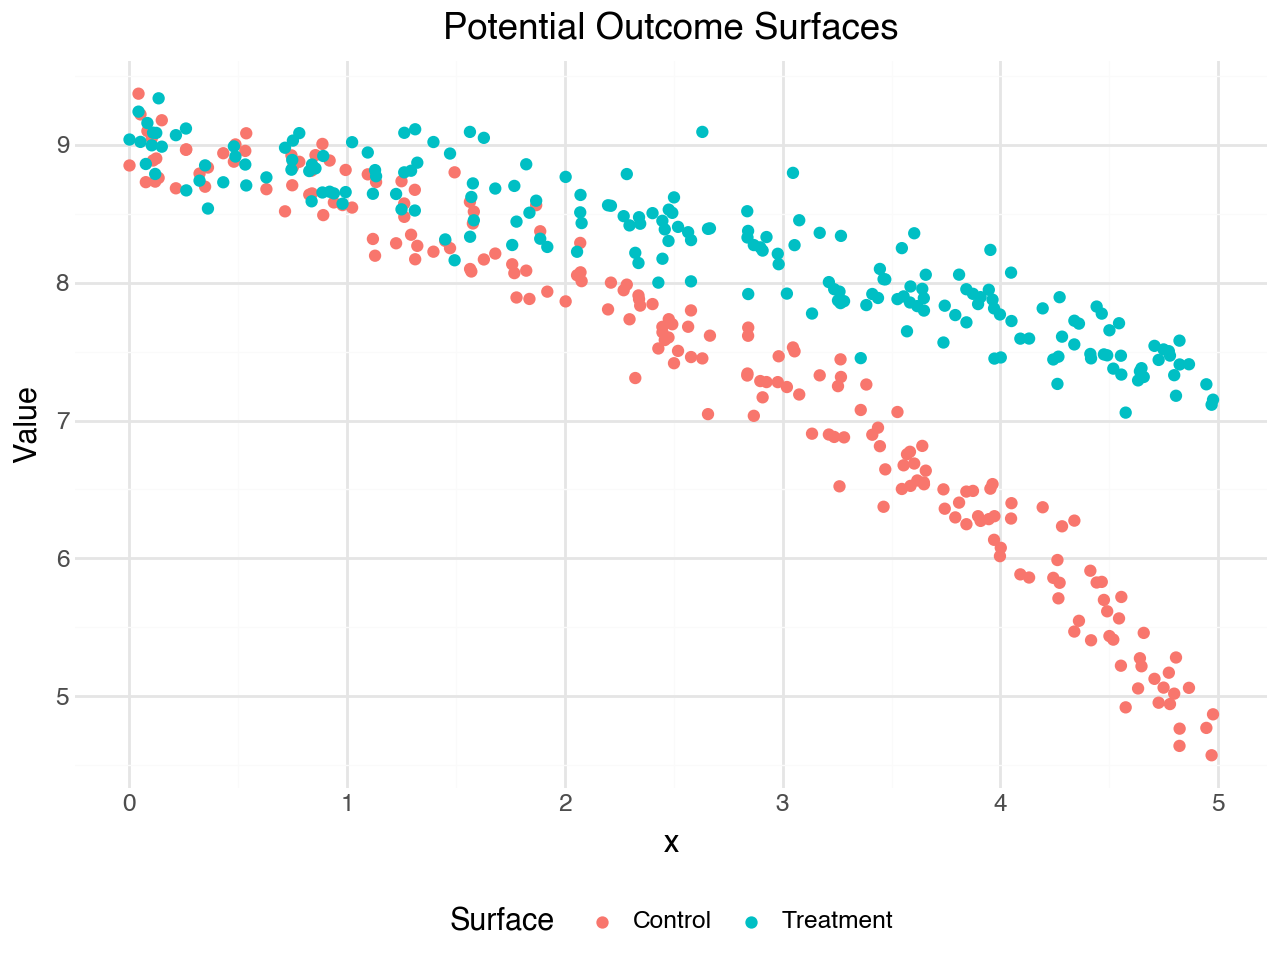

In [10]:
P = generate_population(N_POPULATION)

# Create data for plotting potential outcome surfaces
control_data = P.copy()
control_data['grp'] = 'Control'
control_data['y'] = control_data['y0']

treatment_data = P.copy()
treatment_data['grp'] = 'Treatment'
treatment_data['y'] = treatment_data['y1']

plot_data = pd.concat([control_data[['x', 'y', 'grp']], treatment_data[['x', 'y', 'grp']]], ignore_index=True)

(
p9.ggplot(plot_data, p9.aes("x")) +
p9.geom_point(p9.aes(y = "y", color = "grp")) +
p9.labs(title = "Potential Outcome Surfaces", color = "Surface", y = "Value")
)

In [11]:
pate = np.average(P["y1"] - P["y0"])

print(f"The Population Average Treatment Effect (PATE) is: {pate:0.3f}")

The Population Average Treatment Effect (PATE) is: 0.933


### Sample

We will now take one sample and examine the Sample Average Treatment Effect (SATE) of this sample:

In [12]:
S = srswor(N_SAMPLE, P)
sate = np.average(S["y1"] - S["y0"])

print(f"The SATE is: {sate:0.3f}")

The SATE is: 0.891


In [13]:
S = srswor(N_SAMPLE, P)

## Run an RCT on the sample

In [14]:
E = rct(N_TREATED, S)

n1 = E["a"].sum()
n0 = (1 - E['a']).sum()
print(f"Sample size: {N_SAMPLE}")
print(f"Number treated: {n1}")
print(f"Number in control: {n0}")

Sample size: 40
Number treated: 20
Number in control: 20


### Connection to Lecture: Testing Different Adjustment Methods

Now let's test our three covariate adjustment approaches on this single experiment:

In [15]:
# Compare all three adjustment methods
estimates = estimate_effects(E, methods=["unadjusted", "linear", "lin"])

print(f"=== SINGLE EXPERIMENT COMPARISON ===")
print(f"True SATE in this sample: {sate:.3f}")
print(f"True PATE in population: {pate:.3f}")
print()
print("Method\t\tEstimate\tSE\t95% CI\t\tCovers SATE\tCovers PATE")
print("-" * 75)

method_names = {
    "unadjusted": "Unadjusted",
    "linear": "Linear Adj",
    "lin": "Lin's Method"
}

for method, result in estimates.items():
    tau_hat = result["tau_hat"]
    se_hat = result["se_hat"]
    ci_lower = result["ci_lower"]
    ci_upper = result["ci_upper"]
    
    covers_sate = "✓" if ci_lower <= sate <= ci_upper else "✗"
    covers_pate = "✓" if ci_lower <= pate <= ci_upper else "✗"
    
    print(f"{method_names[method]:<12}\t{tau_hat:.3f}\t\t{se_hat:.3f}\t[{ci_lower:.3f}, {ci_upper:.3f}]\t{covers_sate}\t\t{covers_pate}")

=== SINGLE EXPERIMENT COMPARISON ===
True SATE in this sample: 0.891
True PATE in population: 0.933

Method		Estimate	SE	95% CI		Covers SATE	Covers PATE
---------------------------------------------------------------------------
Unadjusted  	1.704		0.317	[1.082, 2.326]	✗		✗
Linear Adj  	1.200		0.145	[0.915, 1.485]	✗		✓
Lin's Method	1.222		0.086	[1.054, 1.389]	✗		✗


Intrpreting the table:  
Covariate adjustment reduces variance and pulls the estimate toward the truth when X predicts Y.

Coverage checks on one experiment can fail by chance; assess coverage over many experiments (re-randomizations/samples) to see the expected advantages of Lin’s specification.


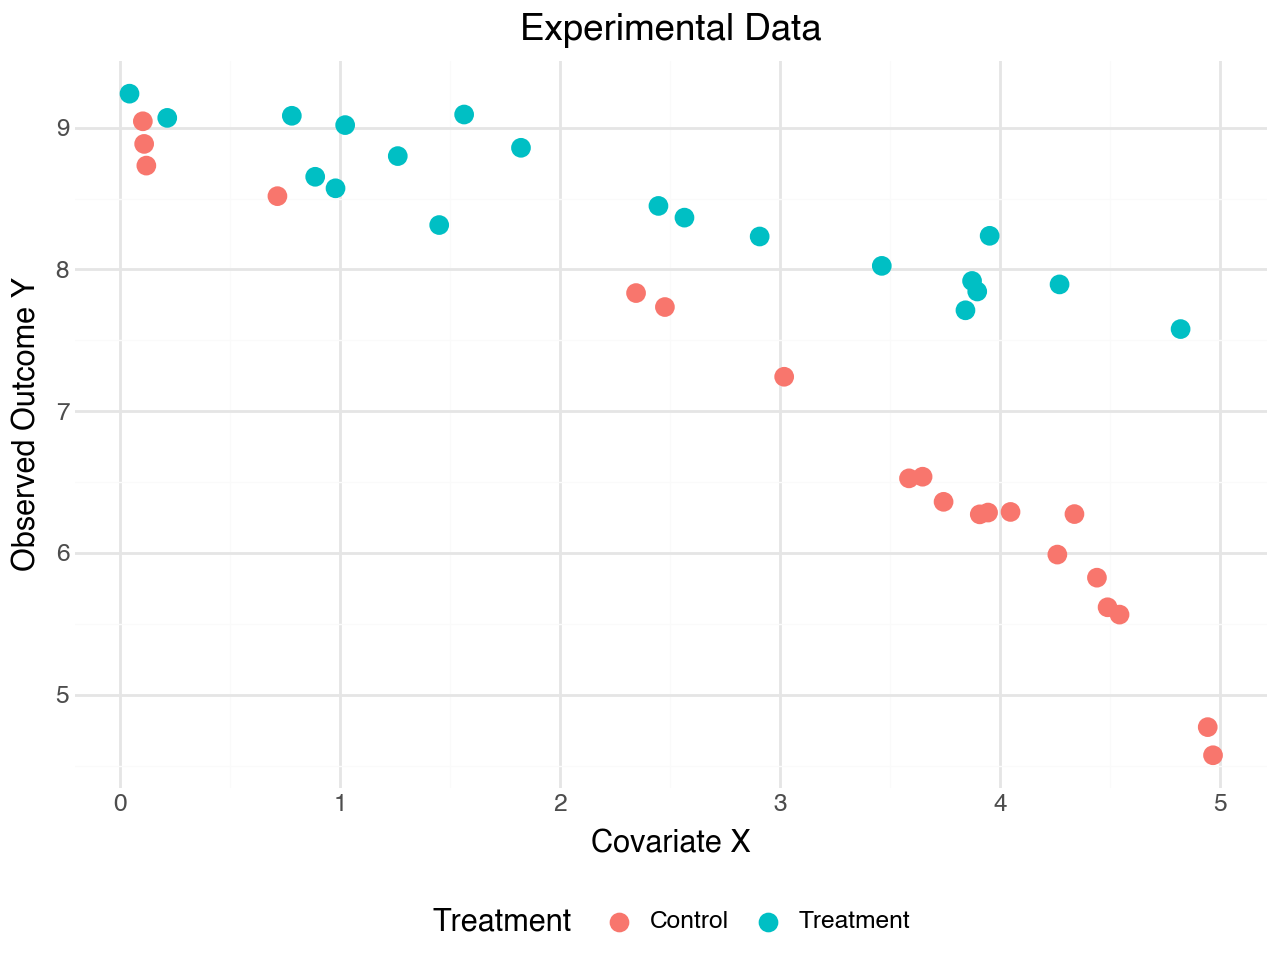

In [16]:
# Visualize the experimental data
(
p9.ggplot(E, p9.aes(x = "x", y = "y", color = "factor(a)")) +
p9.geom_point(size = 3) +
p9.labs(title = "Experimental Data", x = "Covariate X", y = "Observed Outcome Y", 
        color = "Treatment") +
p9.scale_color_discrete(labels = ["Control", "Treatment"])
)

### Visualizing Different Adjustment Approaches

Let's see how the different adjustment methods "see" the data:

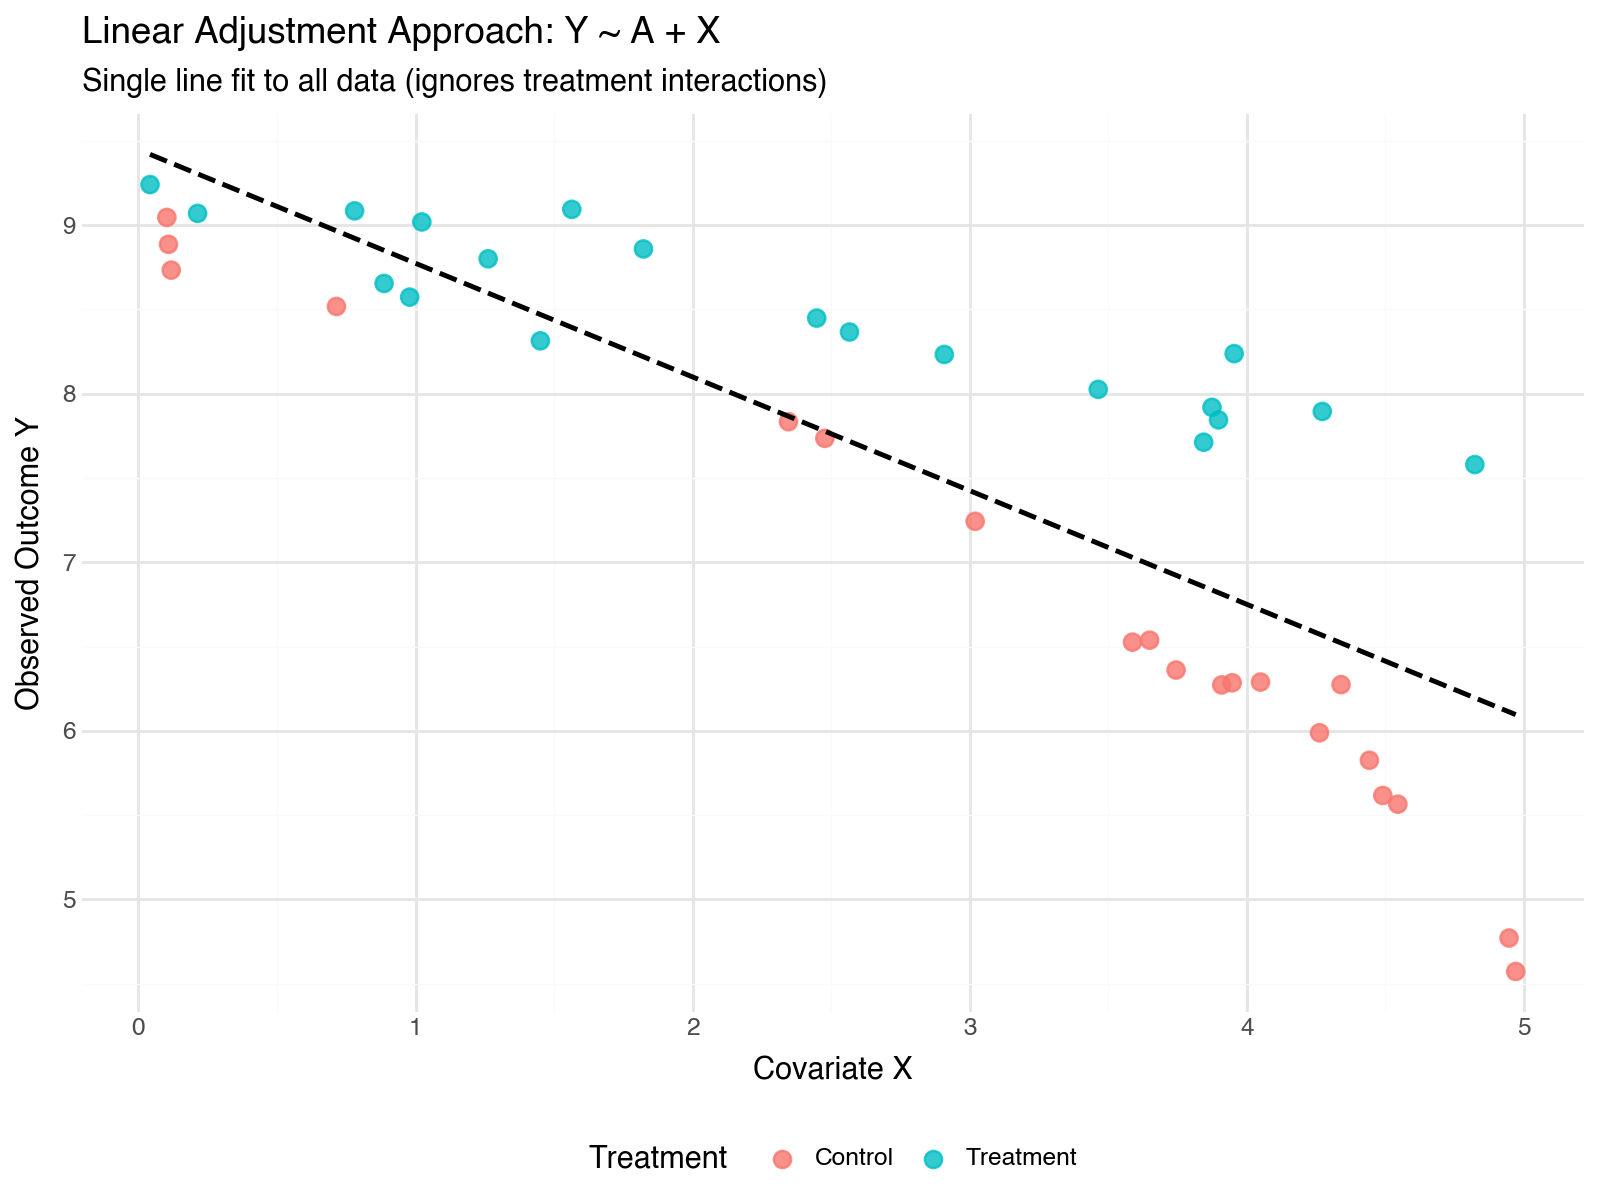

In [17]:
# Linear adjustment: single line through all data
(
    p9.ggplot(E, p9.aes("x", "y", color="factor(a)")) +
    p9.geom_point(size=3, alpha=0.8) +
    p9.geom_smooth(method="lm", se=False, data=E, mapping=p9.aes("x", "y"), 
                   inherit_aes=False, color="black", linetype="dashed") +
    p9.labs(title="Linear Adjustment Approach: Y ~ A + X",
            subtitle="Single line fit to all data (ignores treatment interactions)",
            x="Covariate X", y="Observed Outcome Y", color="Treatment") +
    p9.scale_color_discrete(labels=["Control", "Treatment"]) +
    p9.theme(figure_size=(8, 6))
)

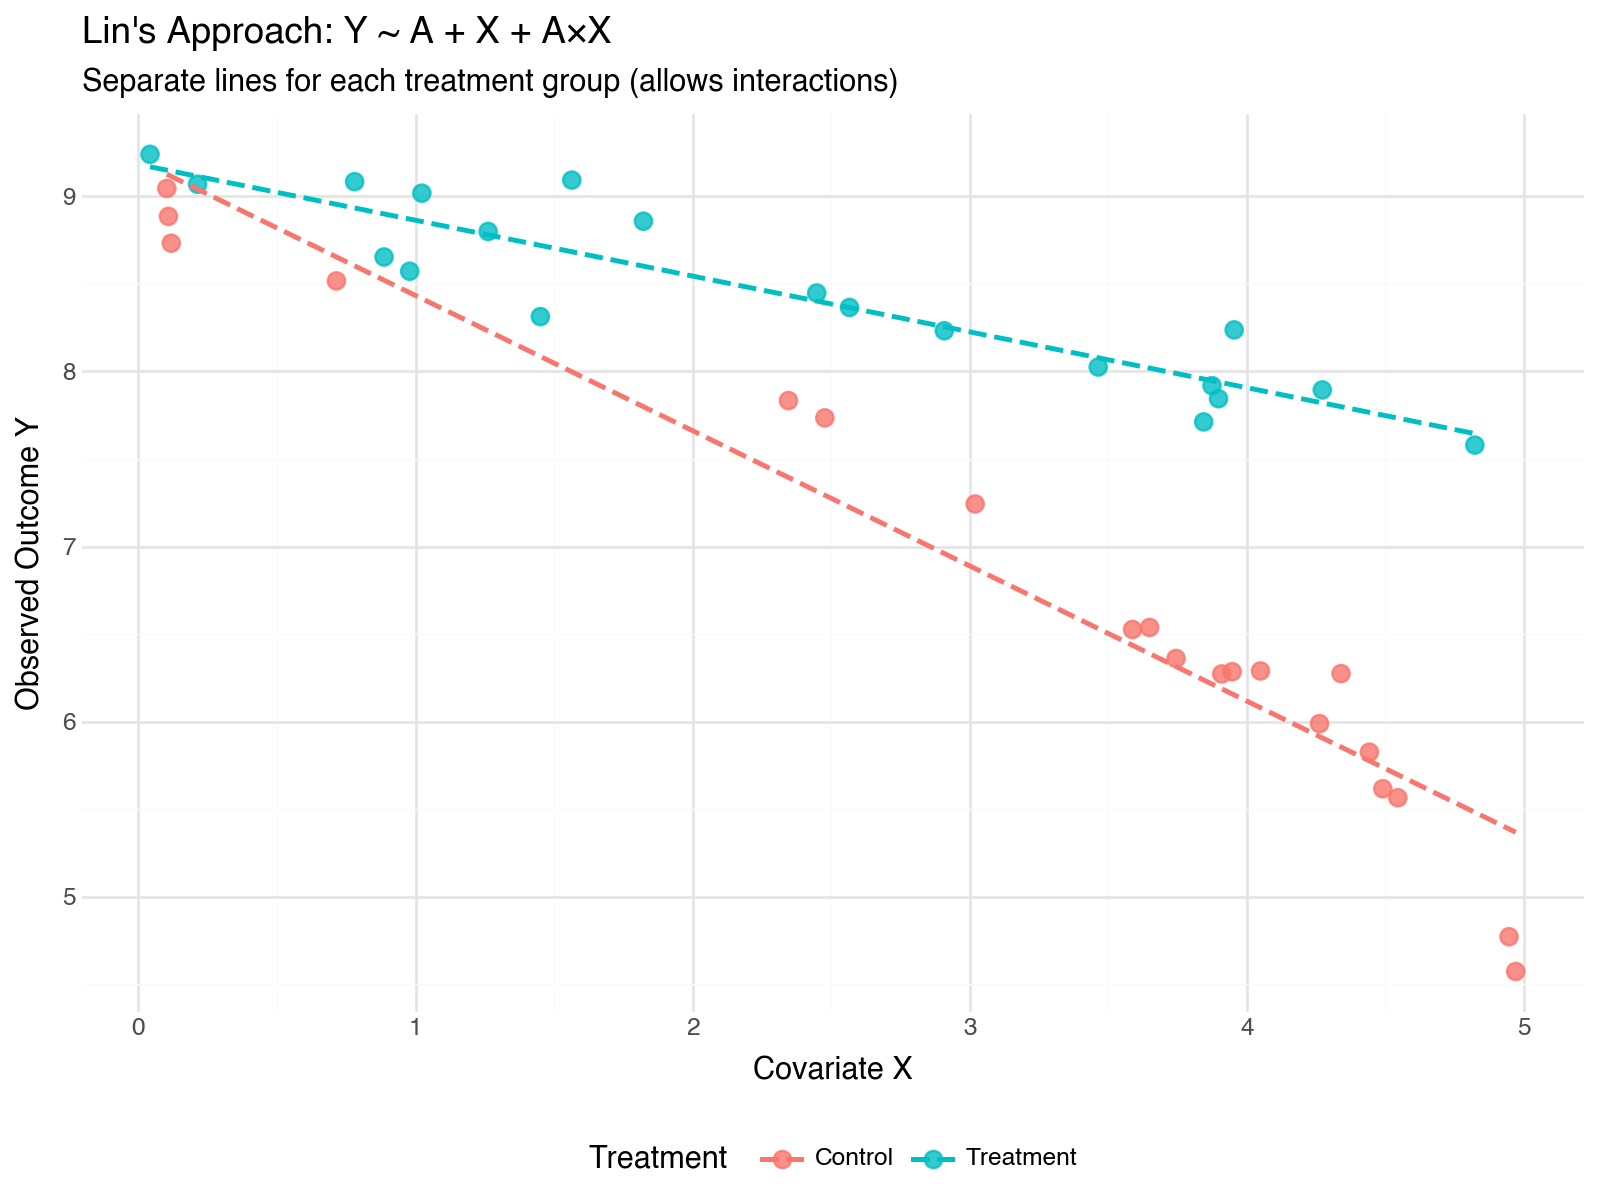

In [18]:
# Lin's approach: separate lines for each treatment group
(
    p9.ggplot(E, p9.aes("x", "y", color="factor(a)")) +
    p9.geom_point(size=3, alpha=0.8) +
    p9.geom_smooth(method="lm", se=False, linetype = "dashed") +
    p9.labs(title="Lin's Approach: Y ~ A + X + A×X",
            subtitle="Separate lines for each treatment group (allows interactions)",
            x="Covariate X", y="Observed Outcome Y", color="Treatment") +
    p9.scale_color_discrete(labels=["Control", "Treatment"]) +
    p9.theme(figure_size=(8, 6))
)

## Put it all together

Now let's run a full simulation to understand the performance of different covariate adjustment methods across many samples and experiments:

In [19]:
# Full simulation: Sample -> RCT -> Compare Adjustment Methods
n_samples = 1000
n_experiments_per_sample = 1

simulation_results = []
methods = ["unadjusted", "linear", "lin"]

for idx_s in range(n_samples):
    # Take a sample from the population
    S = srswor(N_SAMPLE, P)
    sate = np.average(S["y1"] - S["y0"])
    
    for idx_e in range(n_experiments_per_sample):
        # Run an RCT on the sample
        E = rct(N_TREATED, S)
        
        # Estimate using all three methods
        estimates = estimate_effects(E, methods)
        
        for method in methods:
            result = estimates[method]
            tau_hat = result["tau_hat"]
            se_hat = result["se_hat"]
            ci_lower = result["ci_lower"]
            ci_upper = result["ci_upper"]
            
            # Check coverage for both SATE and PATE
            covers_sate = ci_lower <= sate <= ci_upper
            covers_pate = ci_lower <= pate <= ci_upper
            
            simulation_results.append({
                "sample": idx_s,
                "rct": idx_e,
                "method": method,
                "tau_hat": tau_hat,
                "se_hat": se_hat,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
                "covers_sate": covers_sate,
                "covers_pate": covers_pate,
                "sate": sate
            })

# Convert to DataFrame for analysis
sim_full = pd.DataFrame(simulation_results)
print(f"Simulation complete. {n_samples * n_experiments_per_sample * len(methods)} estimates.")

Simulation complete. 3000 estimates.


### Performance Summary: Bias, RMSE, Coverage, and Efficiency

In [20]:
# Calculate performance metrics using DuckDB and SQL with standard errors
# Calculate performance metrics relative to SATE using SQL with standard errors
performance_sate = duckdb.sql(f"""
SELECT 
    method,
    AVG(tau_hat) as tau_hat_mean,
    AVG(sate) as sate_mean,
    STDDEV(tau_hat) as tau_hat_std,
    AVG(CAST(covers_sate AS INTEGER)) as covers_sate_mean,
    AVG(se_hat) as se_hat_mean,
    AVG(tau_hat - sate) as bias_sate,
    STDDEV(tau_hat - sate) / SQRT(COUNT(*)) as bias_sate_se,
    SQRT(AVG(POW(tau_hat - sate, 2))) as rmse_sate,
    STDDEV(POW(tau_hat - sate, 2)) / (2 * SQRT(AVG(POW(tau_hat - sate, 2))) * SQRT(COUNT(*))) as rmse_sate_se
FROM sim_full
GROUP BY method
ORDER BY method
""").df()

# Calculate performance metrics relative to PATE using SQL with standard errors
performance_pate = duckdb.sql(f"""
SELECT 
    method,
    AVG(tau_hat) as tau_hat_mean,
    AVG(CAST(covers_pate AS INTEGER)) as covers_pate_mean,
    AVG(tau_hat - {pate}) as bias_pate,
    STDDEV(tau_hat - {pate}) / SQRT(COUNT(*)) as bias_pate_se,
    SQRT(AVG(POW(tau_hat - {pate}, 2))) as rmse_pate,
    STDDEV(POW(tau_hat - {pate}, 2)) / (2 * SQRT(AVG(POW(tau_hat - {pate}, 2))) * SQRT(COUNT(*))) as rmse_pate_se
FROM sim_full
GROUP BY method
ORDER BY method
""").df()

print("PERFORMANCE RELATIVE TO SATE")
print("=" * 80)
print("Method\t\tBias (SE)\tSD\tRMSE (SE)\tCoverage\tAvg SE")
print("-" * 80)

for _, row in performance_sate.iterrows():
    method = method_names[row["method"]]
    bias = row["bias_sate"]
    bias_se = row["bias_sate_se"]
    sd = row["tau_hat_std"]
    rmse = row["rmse_sate"]
    rmse_se = row["rmse_sate_se"]
    coverage = row["covers_sate_mean"]
    avg_se = row["se_hat_mean"]
    
    print(f"{method:<12}\t{bias:+.3f} ({bias_se:.3f})\t{sd:.3f}\t{rmse:.3f} ({rmse_se:.3f})\t{coverage:.3f}\t\t{avg_se:.3f}")

print(f"\nPERFORMANCE RELATIVE TO PATE")
print("=" * 70)
print("Method\t\tBias (SE)\tRMSE (SE)\tCoverage")
print("-" * 70)

for _, row in performance_pate.iterrows():
    method = method_names[row["method"]]
    bias = row["bias_pate"]
    bias_se = row["bias_pate_se"]
    rmse = row["rmse_pate"]
    rmse_se = row["rmse_pate_se"]
    coverage = row["covers_pate_mean"]
    
    print(f"{method:<12}\t{bias:+.3f} ({bias_se:.3f})\t{rmse:.3f} ({rmse_se:.3f})\t{coverage:.3f}")

PERFORMANCE RELATIVE TO SATE
Method		Bias (SE)	SD	RMSE (SE)	Coverage	Avg SE
--------------------------------------------------------------------------------
Lin's Method	-0.008 (0.002)	0.128	0.070 (0.001)	0.986		0.088
Linear Adj  	-0.003 (0.002)	0.131	0.070 (0.001)	1.000		0.146
Unadjusted  	-0.002 (0.009)	0.298	0.279 (0.006)	0.958		0.304

PERFORMANCE RELATIVE TO PATE
Method		Bias (SE)	RMSE (SE)	Coverage
----------------------------------------------------------------------
Lin's Method	-0.006 (0.004)	0.128 (0.003)	0.822
Linear Adj  	-0.002 (0.004)	0.131 (0.003)	0.972
Unadjusted  	+0.000 (0.009)	0.298 (0.007)	0.946


### Plot distributions of estimates

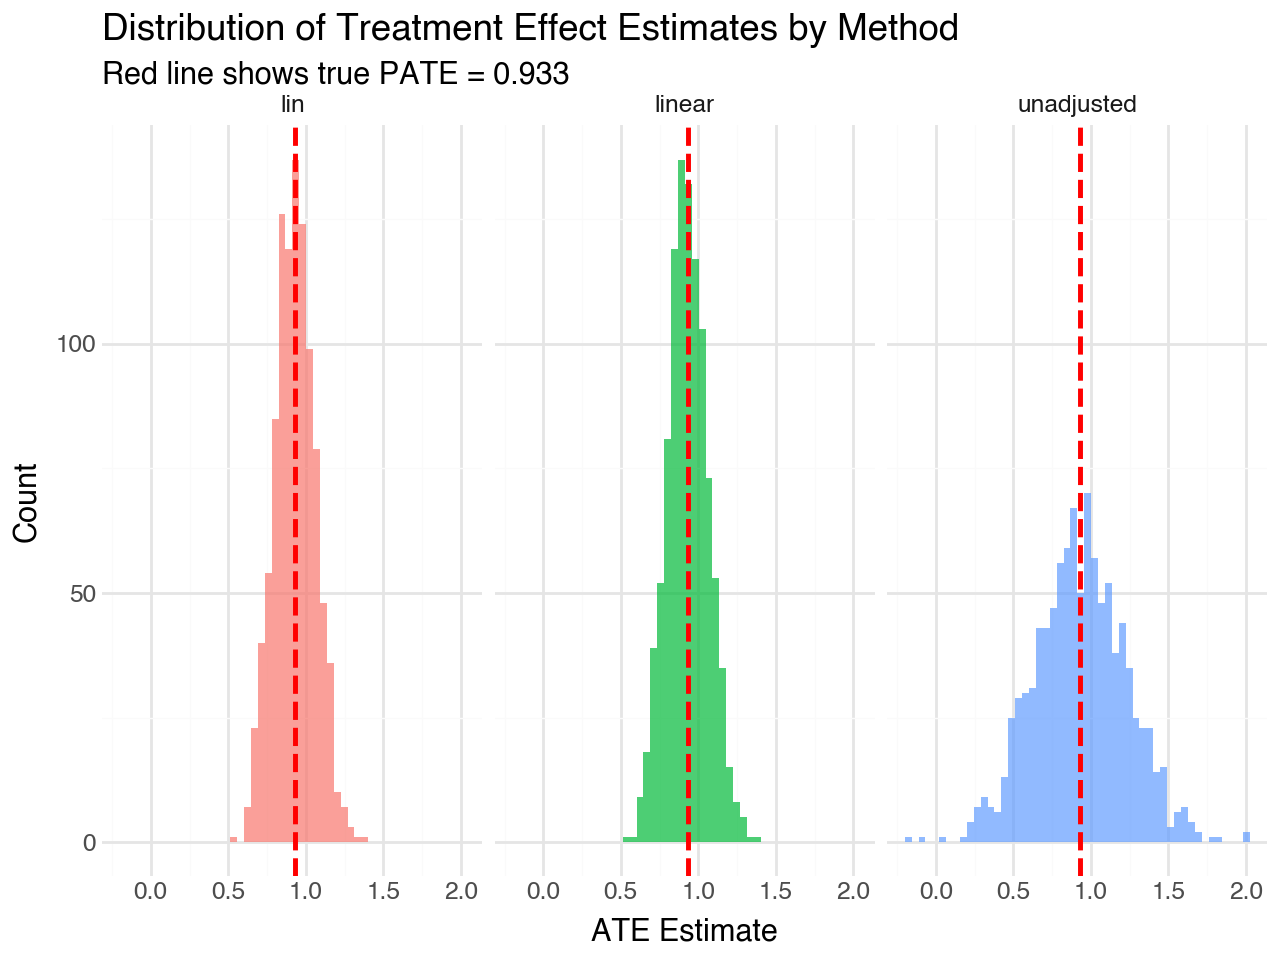

In [21]:
# Visualize the distribution of estimates by method
(
    p9.ggplot(sim_full, p9.aes(x="tau_hat", fill="method")) +
    p9.geom_histogram(alpha=0.7, bins=50, position="identity") +
    p9.geom_vline(xintercept=pate, color="red", linetype="dashed", size=1) +
    p9.facet_wrap("method", nrow=1) +
    p9.labs(title="Distribution of Treatment Effect Estimates by Method",
            subtitle=f"Red line shows true PATE = {pate:.3f}",
            x="ATE Estimate", y="Count") +
    p9.theme(legend_position="none")
)

### Bias and Efficiency Comparison

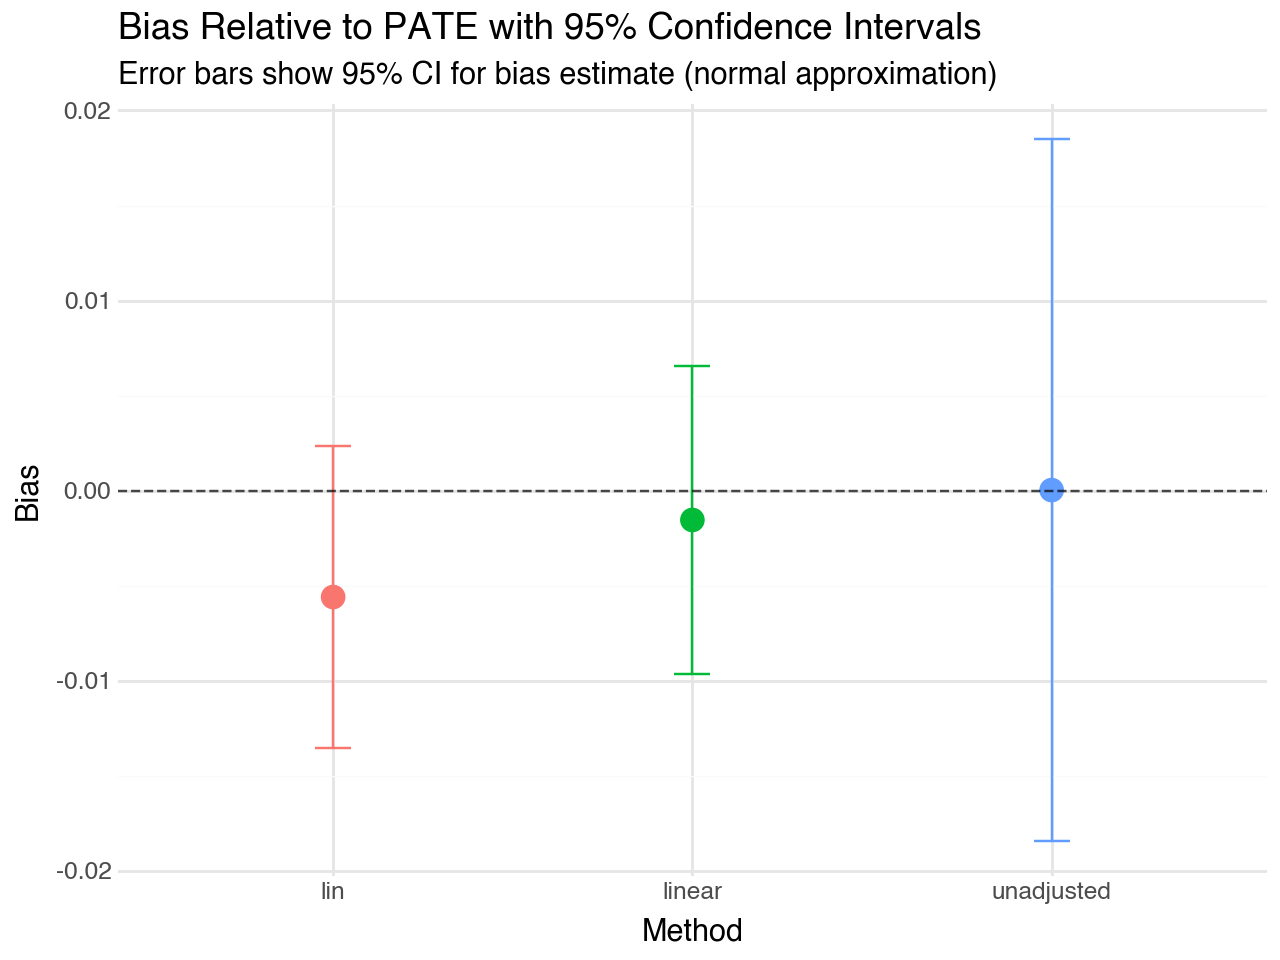

In [22]:
# Join performance data using SQL
performance_plot = duckdb.sql("""
SELECT 
    pp.method,
    pp.bias_pate,
    pp.bias_pate_se,
    pp.rmse_pate,
    pp.rmse_pate_se,
    pp.covers_pate_mean,
    ps.tau_hat_std as sd_estimates
FROM performance_pate pp
JOIN performance_sate ps ON pp.method = ps.method
ORDER BY pp.method
""").df()

(
    p9.ggplot(performance_plot, p9.aes(x="method", y="bias_pate", color="method")) +
    p9.geom_point(size=4) +
    p9.geom_errorbar(p9.aes(ymin="bias_pate - 1.96 * bias_pate_se", ymax="bias_pate + 1.96 * bias_pate_se"), 
                     width=0.1) +
    p9.geom_hline(yintercept=0, linetype="dashed", alpha=0.7) +
    p9.labs(title="Bias Relative to PATE with 95% Confidence Intervals", 
            subtitle="Error bars show 95% CI for bias estimate (normal approximation)",
            x="Method", y="Bias") +
    p9.theme(legend_position="none")
)

### RMSE Comparison (Bias-Variance Trade-off)

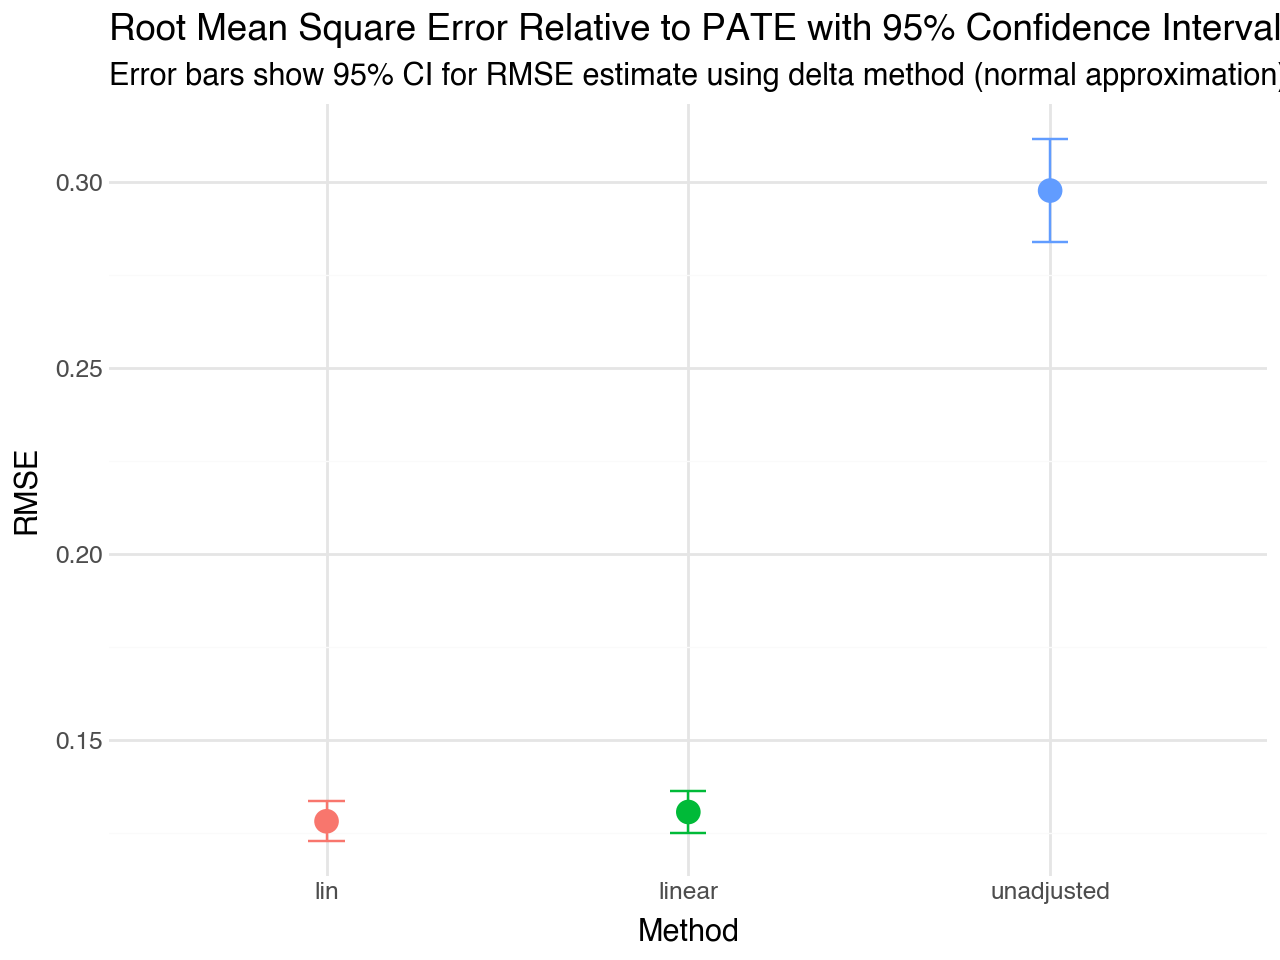

In [23]:
# Compare RMSE with 95% confidence intervals from delta method
(
    p9.ggplot(performance_plot, p9.aes(x="method", y="rmse_pate", color="method")) +
    p9.geom_point(size=4) +
    p9.geom_errorbar(p9.aes(ymin="rmse_pate - 1.96 * rmse_pate_se", ymax="rmse_pate + 1.96 * rmse_pate_se"), 
                     width=0.1) +
    p9.labs(title="Root Mean Square Error Relative to PATE with 95% Confidence Intervals", 
            subtitle="Error bars show 95% CI for RMSE estimate using delta method (normal approximation)",
            x="Method", y="RMSE") +
    p9.theme(legend_position="none")
)

## Things to try / think about

**Modify the simulation to explore:**
- How much of this is Monte Carlo error (i.e. variation from only running a finite number of simulations)?
- How do things change as the sample increases?  
  Distributions get normal.
  
- Are the standard errors for the simulation right? Why or why not?  
  They are Monte Carlo SEs of the reported summaries. They are not the model-based SEs of τ; they’re uncertainty of the simulation
  summaries due to finite R.

- Change around the DGP and see what happens:
  - What if things were linear?
  - Can you make the linear adjustment do worse than the unadjusted estimate?
- Try different covariate adjustment methods:
  - Quadratic adjustment: Y ~ A + X + X²
  - More flexible approaches (splines, polynomials)
  - What if you had prior data on the relationship between Y and X?
- **Coverage properties**: 
  - Are the confidence intervals well-calibrated?
  - How does coverage differ between SATE and PATE inference?